## 1. Import Necessary Modules

In [1]:
%matplotlib inline
import altusi.visualizer as vis
from altusi.logger import *

In [2]:
import mxnet as mx
from mxnet import nd, autograd, init, gluon, context
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.data import transforms as gcv_transforms
from gluoncv.utils import TrainingHistory

## 2. Load Data

### 2.1 Specify Dataset Information

In [3]:
IMAGE_SIZE = 32
CLASSES = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### 2.2 Create Data Transformer

In [4]:
train_transformer = transforms.Compose([
    gcv_transforms.RandomCrop(IMAGE_SIZE, pad=4),
    transforms.RandomFlipLeftRight(),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

test_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

LOG(INFO, 'Data Trasformer creating done')

[2019-08-06 18:00:51] [INFO]  Data Trasformer creating done


### 2.3 Load Dataset and Apply Transformations

In [5]:
train_dataset = gluon.data.vision.CIFAR10(train=True)
test_dataset  = gluon.data.vision.CIFAR10(train=False)

LOG(INFO, 'Dataset loading done')

[2019-08-06 18:00:52] [INFO]  Dataset loading done


In [6]:
X, y = train_dataset[:10]

In [7]:
X.shape

(10, 32, 32, 3)

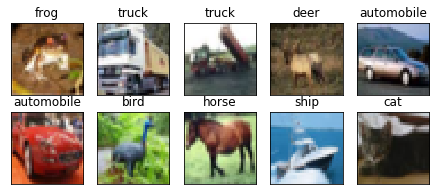

In [8]:
vis.show_images(X, 2, 5, [CLASSES[cls] for cls in y])

In [9]:
train_dataset = train_dataset.transform_first(train_transformer)
test_dataset = test_dataset.transform_first(test_transformer)

LOG(INFO, 'Data Transforming done')

[2019-08-06 18:00:52] [INFO]  Data Transforming done


### 2.4 Create Data Loader

In [10]:
BATCH_SIZE = 32
BATCH_SIZE *= context.num_gpus()

train_loader = gluon.data.DataLoader(train_dataset, 
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=4)

test_loader = gluon.data.DataLoader(test_dataset, 
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=4)

LOG(INFO, 'Data Loader creating done')

[2019-08-06 18:00:53] [INFO]  Data Loader creating done


## 3. Setup Network

In [11]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=16, kernel_size=5, pa),
       nn.Activation('relu'),
       nn.MaxPool2D(pool_size=2, strides=2),
       nn.Conv2D(channels=32, kernel_size=5),
       nn.Activation('relu'),
       nn.MaxPool2D(pool_size=2, strides=2),
       nn.Dense(256, activation='relu'),
       nn.Dense(len(CLASSES)))

In [12]:
net.initialize()
X = nd.random.uniform(shape=(1, 3, 32, 32))
X.shape

(1, 3, 32, 32)

In [13]:
net(X)


[[-0.07083606  0.00815132 -0.04985899  0.05851745 -0.07446058  0.06483295
   0.1272366   0.05255632 -0.05936174 -0.08763427]]
<NDArray 1x10 @cpu(0)>

## 4. Setup Training System

In [14]:
from gluoncv.model_zoo import get_model, get_model_list

In [15]:
kwargs = {'classes':len(CLASSES)}
net = get_model('cifar_resnet20_v1', **kwargs)

In [16]:
LR = 0.1
LR_EPOCH_DROP = [10, 20, 30, 40, 50]
LR_DECAY_FACTOR = 0.5
WD = 0.0005
MOMENTUM = 0.9
NEPOCHS = 50

ctx = [context.gpu(gpu_idx) for gpu_idx in range(context.num_gpus())]
LOG(INFO, 'GPUs in Use:\n', ctx)

net.initialize(init.Xavier(), force_reinit=True, ctx=ctx)

criterion = gluon.loss.SoftmaxCrossEntropyLoss()
optimizer = 'sgd'

trainer = gluon.Trainer(net.collect_params(), 
                        optimizer,
                        {'learning_rate': LR, 'wd': WD, 'momentum':MOMENTUM})

train_history = TrainingHistory(['train-loss', 'test-loss', 'train-acc', 'test-acc'])

[2019-08-06 18:00:53] [INFO]  GPUs in Use:
 [gpu(0), gpu(1)]


### 4.1 Define Test Procedure

In [17]:
def test(net, test_loader, criterion, ctx):
    sample_cnt = 0
    test_loss = 0
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(test_loader):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        labels = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        
        preds = [net(X) for X in data]
        loss = [criterion(y_hat, y) for y_hat, y in zip(preds, labels)]
        test_loss += sum([l.sum().asscalar() for l in loss])
        sample_cnt += sum([len(X) for X in data])
        
        metric.update(labels, preds)
    return metric.get(), test_loss / sample_cnt

### 4.2 Define Training Procedure

[2019-08-06 18:19:55] [INFO]  Training Procedure done


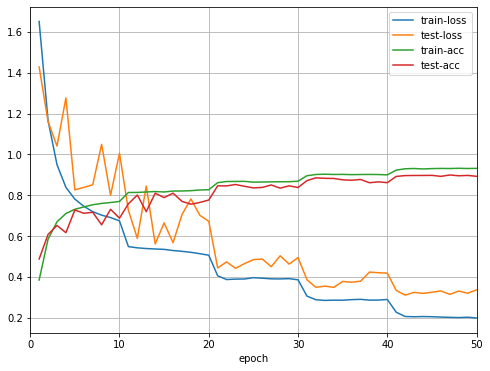

In [18]:
lr_drop_idx = 0

train_metric = mx.metric.Accuracy()
animator = vis.Animator(xlabel='epoch', legend=['train-loss', 'test-loss', 'train-acc', 'test-acc'],
                       xlim=[0, NEPOCHS], figsize=(8, 6))

for epoch in range(NEPOCHS):
    train_loss = 0
    train_metric.reset()
    
    if epoch == LR_EPOCH_DROP[lr_drop_idx]:
        trainer.set_learning_rate(trainer.learning_rate * LR_DECAY_FACTOR)
        lr_drop_idx += 1
    
    for i, batch in enumerate(train_loader):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        labels = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        
        with autograd.record():
            preds = [net(X) for X in data]
            loss = [criterion(y_hat, y) for y_hat, y in zip(preds, labels)]
            
        for l in loss:
            l.backward()
            
        trainer.step(BATCH_SIZE)
        
        train_loss += sum([l.sum().asscalar() for l in loss])
        train_metric.update(labels, preds)
        
    train_loss /= BATCH_SIZE * len(train_loader)
    name, train_acc = train_metric.get()
    
    (name, test_acc), test_loss = test(net, test_loader, criterion, ctx)
    
    LOG(INFO, 'Epoch: ', epoch)
    LOG(DEBUG, '\ttrain-loss: {:.4f}'.format(train_loss))
    LOG(DEBUG, '\ttest-loss:  {:.4f}'.format(test_loss))
    LOG(DEBUG, '\ttrain-acc:  {:.4f}'.format(train_acc))
    LOG(DEBUG, '\ttest-acc:   {:.4f}'.format(test_acc))
    
    animator.add(epoch+1, (train_loss, test_loss, train_acc, test_acc))
    
LOG(INFO, 'Training Procedure done')   

In [19]:
(name, test_acc), test_loss = test(net, test_loader, criterion, ctx)
LOG(INFO, 'Accuracy: {:.4f}'.format(test_acc))

[2019-08-06 18:19:57] [INFO]  Accuracy: 0.8924
